In [1]:
%%bash
   export JAVA_OPTS="-Xmx64g"

In [2]:
# Imports
import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans, GaussianMixture, BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt

Matplotlib created a temporary cache directory at /tmp/matplotlib-aq8yf_50 because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
# This cell checks if the file merged_data.csv exists in the current directory.
# If it doesn't, it installs the kaggle package, downloads the Spotify dataset
# from Kaggle, and unzips the downloaded file.

file_exists = os.path.exists('merged_data.csv')

if not file_exists:
    !pip install kaggle
    !kaggle datasets download -d sunnykakar/spotify-charts-all-audio-data
    !unzip spotify-charts-all-audio-data.zip

In [4]:
# This cell initializes a Spark session and loads the dataset merged_data.csv into a
# Spark DataFrame
print("Initializing Spark Session...")
spark = SparkSession.builder \
    .appName("FeatureSelectionClustering") \
    .getOrCreate()
print("Spark Session initialized.")

print("Loading dataset...")
df = spark.read.csv('merged_data.csv', header=True, inferSchema=True)
print("Dataset loaded.")

Initializing Spark Session...
Spark Session initialized.
Loading dataset...
Dataset loaded.


In [5]:
# This cell renames the column _c0 to ID in the DataFrame, then handles missing values
# by filling them with the mean value of each specified feature in audio_features,
# casts these feature columns to float type, and finally drops any remaining rows with null values.

# Rename _c0 Column
df = df.withColumnRenamed('_c0', 'ID')

# Audio features
audio_features = [
    'af_danceability', 'af_energy', 'af_key', 'af_loudness', 'af_mode', 'af_speechiness',
    'af_acousticness', 'af_instrumentalness', 'af_liveness', 'af_valence', 'af_tempo', 'af_time_signature'
]
# Handle missing values and cast columns to float
print("Handling missing values and casting columns to float...")
for feature in audio_features:
    mean_value = df.select(avg(col(feature))).first()[0]
    df = df.fillna({feature: mean_value})
    df = df.withColumn(feature, col(feature).cast('float'))

print("Dropping remaining rows with null values")
df = df.dropna()

Handling missing values and casting columns to float...
Dropping remaining rows with null values


In [6]:
# This cell creates a feature vector using VectorAssembler and scales
# these features using StandardScaler.
# The transformed DataFrame is stored in a new column scaledFeatures.

# Assemble features into a single vector
print("Assembling features into a single vector...")
assembler = VectorAssembler(inputCols=audio_features, outputCol="features")
df = assembler.transform(df)

# Scale the features
print("Scaling the features...")
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
scaler_model = scaler.fit(df)
df = scaler_model.transform(df)

Assembling features into a single vector...
Scaling the features...


In [7]:
# This cell evaluates the performance of KMeans, Gaussian Mixture Model (GMM),
# and Bisecting KMeans clustering algorithms for different values of k.
# For each value of k, it trains the models, makes predictions,
# and computes the Silhouette score to assess the quality of the clustering.
# The results are printed and stored in respective lists for comparison.

print("Evaluating KMeans, GMM, and Bisecting KMeans with different values of k...")
ks = [2, 3, 4, 5, 6, 7, 8, 9, 10]
silhouettes_kmeans = []
silhouettes_gmm = []
silhouettes_bkm = []

evaluator = ClusteringEvaluator(featuresCol="scaledFeatures")

for k in ks:
    print(f"Training models with k={k}...")

    # KMeans model
    kmeans = KMeans(featuresCol="scaledFeatures", k=k, seed=1)
    kmeans_model = kmeans.fit(df)

    # KMeans evaluation
    predictions_kmeans = kmeans_model.transform(df)
    silhouette_kmeans = evaluator.evaluate(predictions_kmeans)
    silhouettes_kmeans.append(silhouette_kmeans)

    print(f"KMeans Silhouette score for k={k}: {silhouette_kmeans}")

    # GMM model
    gmm = GaussianMixture(featuresCol="scaledFeatures", k=k, seed=1)
    gmm_model = gmm.fit(df)

    # GMM evaluation
    predictions_gmm = gmm_model.transform(df)
    silhouette_gmm = evaluator.evaluate(predictions_gmm)
    silhouettes_gmm.append(silhouette_gmm)

    print(f"GMM Silhouette score for k={k}: {silhouette_gmm}")

    # Bisecting KMeans model
    bkm = BisectingKMeans(featuresCol="scaledFeatures", k=k, seed=1)
    bkm_model = bkm.fit(df)

    # BKM evaluation
    predictions_bkm = bkm_model.transform(df)
    silhouette_bkm = evaluator.evaluate(predictions_bkm)
    silhouettes_bkm.append(silhouette_bkm)

    print(f"BKM Silhouette score for k={k}: {silhouette_bkm}")

Evaluating KMeans, GMM, and Bisecting KMeans with different values of k...
Training models with k=2...
KMeans Silhouette score for k=2: 0.31917879943367944
GMM Silhouette score for k=2: 0.5691867658166606
BKM Silhouette score for k=2: 0.3191386179489607
Training models with k=3...
KMeans Silhouette score for k=3: 0.2302149458254081
GMM Silhouette score for k=3: 0.20090535580590727
BKM Silhouette score for k=3: 0.14742256743499105
Training models with k=4...
KMeans Silhouette score for k=4: 0.2215222087350883
GMM Silhouette score for k=4: 0.39810381171872894
BKM Silhouette score for k=4: 0.1913114356528095
Training models with k=5...
KMeans Silhouette score for k=5: 0.16885429299529606
GMM Silhouette score for k=5: 0.16664667982698309
BKM Silhouette score for k=5: 0.13871905429574408
Training models with k=6...
KMeans Silhouette score for k=6: 0.1771171640309518
GMM Silhouette score for k=6: 0.11844719791185665
BKM Silhouette score for k=6: 0.1264651452240034
Training models with k=7...

Plotting the results...


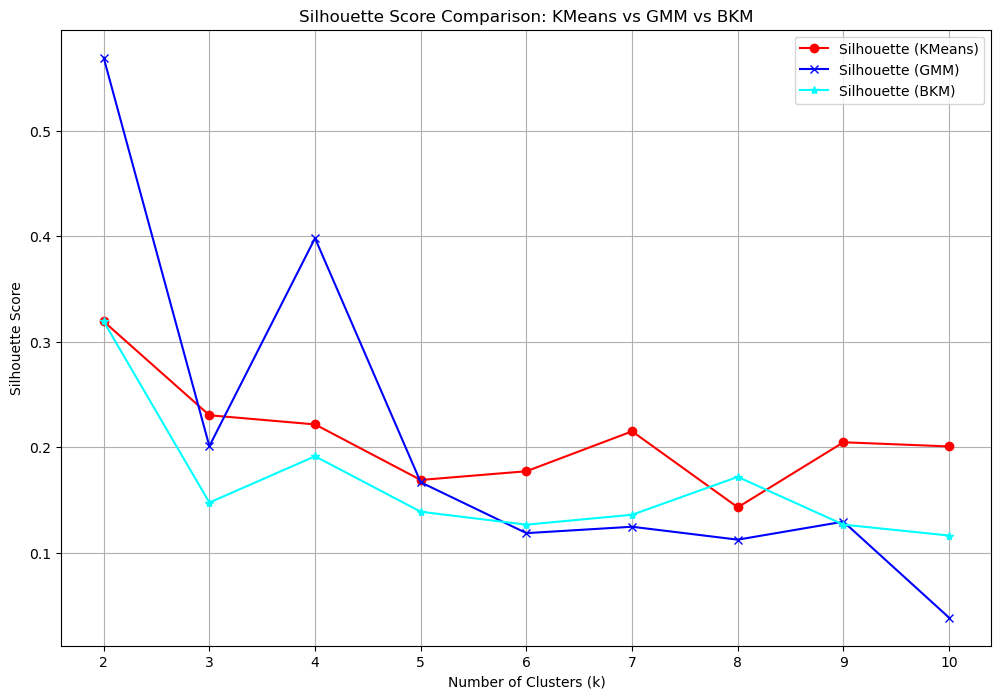

Plot displayed.


In [8]:
# This cell generates and displays a plot comparing the Silhouette scores of KMeans,
# Gaussian Mixture Model (GMM), and Bisecting KMeans (BKM) clustering algorithms
# for different values of k (number of clusters).
# The plot helps visualize the performance of each algorithm across various cluster counts

print("Plotting the results...")
plt.figure(figsize=(12, 8))

plt.plot(ks, silhouettes_kmeans, label='Silhouette (KMeans)', marker='o', color='red')
plt.plot(ks, silhouettes_gmm, label='Silhouette (GMM)', marker='x', color='blue')
plt.plot(ks, silhouettes_bkm, label='Silhouette (BKM)', marker='*', color='cyan')

plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Comparison: KMeans vs GMM vs BKM')
plt.legend()
plt.grid(True)
plt.show()
print("Plot displayed.")